Test SolvePNP

In [1]:
import os
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import numpy as np
from math import sin, tan, cos, pi, radians, degrees

def cMatrix(fLength,cx,cy):
    return np.array([[fLength,0,cx,0],[0,fLength,cy,0],[0,0,1,0]])

def eulerAnglesToRotationMatrix(theta) :
     
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         cos(theta[0]), -sin(theta[0]) ],
                    [0,         sin(theta[0]), cos(theta[0])  ]
                    ])
         
         
                     
    R_y = np.array([[cos(theta[1]),    0,      sin(theta[1])  ],
                    [0,                1,      0                   ],
                    [-sin(theta[1]),   0,      cos(theta[1])  ]
                    ])
                 
    R_z = np.array([[cos(theta[2]),    -sin(theta[2]),    0],
                    [sin(theta[2]),    cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])
                     
                     
    R = np.dot(R_z, np.dot( R_y, R_x ))
 
    return R

In [2]:
objX=[]
objY=[]
objZ=[]

imagePoints = pd.read_csv('../data/interim/2dprojpts530.csv',sep=',', skiprows=[1,2])
imagePoints['X'] = imagePoints['X'].astype('float32')
imagePoints['Y'] = imagePoints['Y'].astype('float32')
imagePointVal = imagePoints.iloc[:,1:].values

MCapVal = pd.read_pickle('../data/processed/01.pickle')
MCapFrame = MCapVal.iloc[2400]
MCapOrdered = MCapFrame.reindex(imagePoints['Name'].tolist()).dropna()

for i in range(len(MCapOrdered)):
    objX.append(MCapOrdered[i][0][0])
    objY.append(MCapOrdered[i][1][0])
    objZ.append(MCapOrdered[i][2][0])

objMat = np.array((objX,objY,objZ))    

In [3]:
cameraMatrix = cMatrix(267.3,352/2,240/2)
cameraMatrix=cameraMatrix[:,:-1]

rotx = radians(0)
roty = radians(50)
rotz = radians(0)
transx = -40
transy = -10
transz = 30

distCoeffs=0
rvec = np.array([rotx,roty,rotz])
tvec = np.array([transx,transy,transz]).astype('float32')

pnpVal = cv2.solvePnP(
    objMat.T,
    imagePointVal,
    cameraMatrix,
    distCoeffs,
    rvec,
    tvec,
    useExtrinsicGuess=1)

In [16]:
rMat = eulerAnglesToRotationMatrix(pnpVal[1])
tvec = pnpVal[2]
wMat = np.c_[rMat,tvec]

projMCap = []

for i in range(MCapFrame.shape[0]):
    subMCap = MCapFrame.iloc[i]
    subMCap = np.append(subMCap,[1.])
    projMCap.append(np.linalg.multi_dot([cameraMatrix,wMat,subMCap]))

projMCap = pd.DataFrame(projMCap,columns = ['x','y','z'], index=MCapFrame.keys())
projMCap['x'] = projMCap['x']/projMCap['z']
projMCap['y'] = projMCap['y']/projMCap['z']

projMCap = projMCap.drop(columns = ['z'])

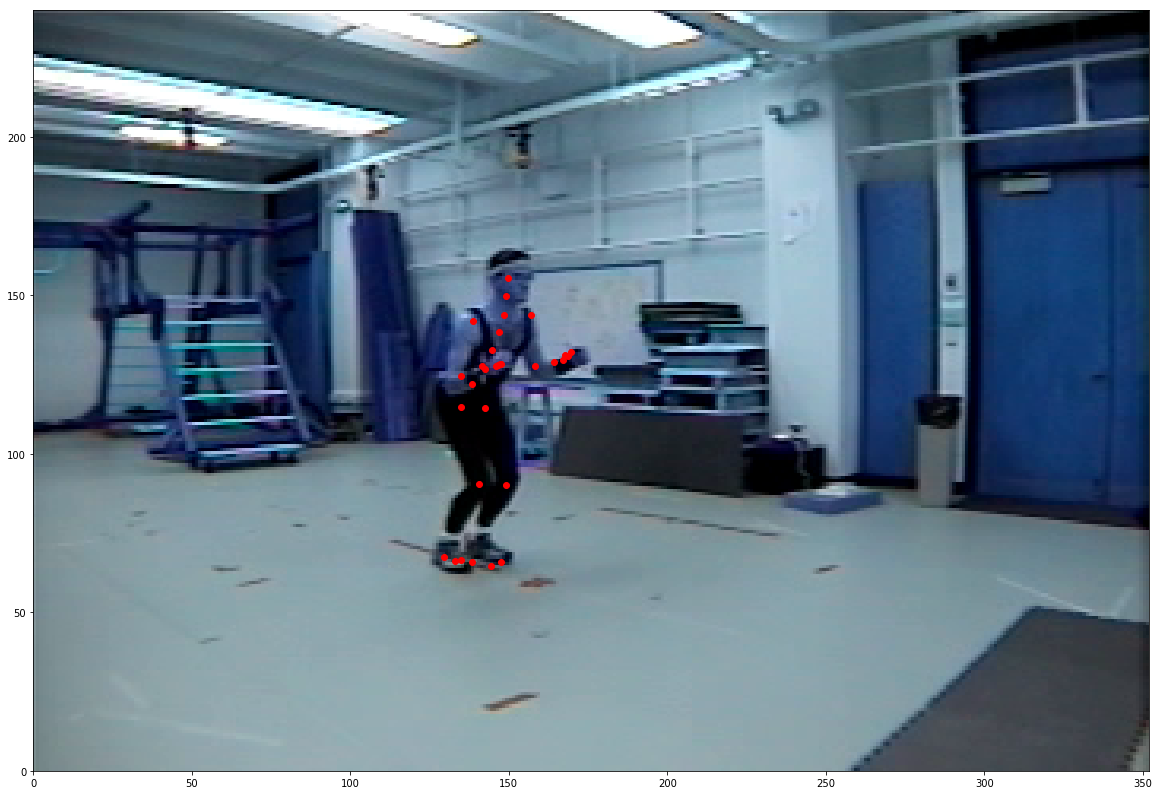

In [5]:
Vidframe=530

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

vidcap = cv2.VideoCapture('../data/raw/01_01.mpg')
vidcap.set(cv2.CAP_PROP_POS_FRAMES,Vidframe)
success, image = vidcap.read()

ax.imshow(image,aspect='equal', extent=[0,vidcap.get(3),0,vidcap.get(4)])

ax.scatter(projMCap['x'],projMCap['y'], color='r')

In [19]:

projMCap.to_pickle('../data/processed/01proj.pickle')

In [20]:
pd.read_pickle('../data/processed/01proj.pickle')

,x,y
root,138.335796,121.859102
lhipjoint,142.398501,114.376534
lfemur,149.026938,90.111834
ltibia,138.347556,65.811143
lfoot,144.466459,64.748924
ltoes,147.470615,65.702742
rhipjoint,134.867114,114.873506
rfemur,140.510640,90.577954
rtibia,129.496483,67.531962
rfoot,133.047427,66.024913
